In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=300):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [4]:
## Resample training data
#resample_data(train_dir)
#resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 3500 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model with L2 regularization
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers with L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)

# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 299, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 299, 224, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'InceptionResNetV2.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Epoch 1/1000
126/126 [==============================] - 36s 274ms/step
Epoch 1 - Validation Loss: 4.0439, Validation Accuracy: 0.1262, Validation Precision: 0.0273

Epoch 1: val_loss improved from inf to 4.04394, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 289s - loss: 4.7391 - acc: 0.1689 - val_loss: 4.0439 - val_acc: 0.1262 - lr: 1.0000e-04 - 289s/epoch - 1s/step
Epoch 2/1000
126/126 [==============================] - 34s 272ms/step
Epoch 2 - Validation Loss: 3.1931, Validation Accuracy: 0.1397, Validation Precision: 0.0299

Epoch 2: val_loss improved from 4.04394 to 3.19308, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 257s - loss: 3.5528 - acc: 0.1877 - val_loss: 3.1931 - val_acc: 0.1397 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 3/1000
126/126 [==============================] - 34s 272ms/step
Epoch 3 - Validation Loss: 2.8469, Validation Accuracy: 0.1262, Validation Precision: 0.0321

Epoch 3: val_loss improved from 3.19308 to 2.84694, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 257s - loss: 2.9678 - acc: 0.2026 - val_loss: 2.8469 - val_acc: 0.1262 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 4/1000
126/126 [==============================] - 34s 272ms/step
Epoch 4 - Validation Loss: 2.5295, Validation Accuracy: 0.1227, Validation Precision: 0.0293

Epoch 4: val_loss improved from 2.84694 to 2.52953, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 257s - loss: 2.6124 - acc: 0.2311 - val_loss: 2.5295 - val_acc: 0.1227 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 5/1000
126/126 [==============================] - 34s 272ms/step
Epoch 5 - Validation Loss: 2.3098, Validation Accuracy: 0.1416, Validation Precision: 0.0510

Epoch 5: val_loss improved from 2.52953 to 2.30979, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 257s - loss: 2.4089 - acc: 0.2334 - val_loss: 2.3098 - val_acc: 0.1416 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 6/1000
126/126 [==============================] - 34s 274ms/step
Epoch 6 - Validation Loss: 2.2194, Validation Accuracy: 0.1526, Validation Precision: 0.0413

Epoch 6: val_loss improved from 2.30979 to 2.21935, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 2.2598 - acc: 0.2243 - val_loss: 2.2194 - val_acc: 0.1526 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 7/1000
126/126 [==============================] - 34s 274ms/step
Epoch 7 - Validation Loss: 2.2591, Validation Accuracy: 0.1082, Validation Precision: 0.0228

Epoch 7: val_loss did not improve from 2.21935
219/219 - 257s - loss: 2.1609 - acc: 0.2274 - val_loss: 2.2591 - val_acc: 0.1082 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 277ms/step
Epoch 8 - Validation Loss: 2.0425, Validation Accuracy: 0.1511, Validation Precision: 0.0502

Epoch 8: val_loss improved from 2.21935 to 2.04251, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 263s - loss: 2.0866 - acc: 0.2197 - val_loss: 2.0425 - val_acc: 0.1511 - lr: 1.0000e-04 - 263s/epoch - 1s/step
Epoch 9/1000
126/126 [==============================] - 36s 287ms/step
Epoch 9 - Validation Loss: 1.9750, Validation Accuracy: 0.1382, Validation Precision: 0.0281

Epoch 9: val_loss improved from 2.04251 to 1.97501, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 262s - loss: 2.0130 - acc: 0.2414 - val_loss: 1.9750 - val_acc: 0.1382 - lr: 1.0000e-04 - 262s/epoch - 1s/step
Epoch 10/1000
126/126 [==============================] - 34s 269ms/step
Epoch 10 - Validation Loss: 1.9305, Validation Accuracy: 0.1496, Validation Precision: 0.0366

Epoch 10: val_loss improved from 1.97501 to 1.93054, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 257s - loss: 1.9663 - acc: 0.2794 - val_loss: 1.9305 - val_acc: 0.1496 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 11/1000
126/126 [==============================] - 36s 284ms/step
Epoch 11 - Validation Loss: 1.8996, Validation Accuracy: 0.1466, Validation Precision: 0.0397

Epoch 11: val_loss improved from 1.93054 to 1.89963, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 264s - loss: 1.9009 - acc: 0.3017 - val_loss: 1.8996 - val_acc: 0.1466 - lr: 1.0000e-04 - 264s/epoch - 1s/step
Epoch 12/1000
126/126 [==============================] - 34s 274ms/step
Epoch 12 - Validation Loss: 1.8901, Validation Accuracy: 0.1357, Validation Precision: 0.0262

Epoch 12: val_loss improved from 1.89963 to 1.89006, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 262s - loss: 1.8877 - acc: 0.2877 - val_loss: 1.8901 - val_acc: 0.1357 - lr: 1.0000e-04 - 262s/epoch - 1s/step
Epoch 13/1000
126/126 [==============================] - 35s 278ms/step
Epoch 13 - Validation Loss: 1.7974, Validation Accuracy: 0.1516, Validation Precision: 0.0388

Epoch 13: val_loss improved from 1.89006 to 1.79741, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 263s - loss: 1.8594 - acc: 0.2777 - val_loss: 1.7974 - val_acc: 0.1516 - lr: 1.0000e-04 - 263s/epoch - 1s/step
Epoch 14/1000
126/126 [==============================] - 37s 296ms/step
Epoch 14 - Validation Loss: 1.7854, Validation Accuracy: 0.1466, Validation Precision: 0.0240

Epoch 14: val_loss improved from 1.79741 to 1.78538, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 272s - loss: 1.8034 - acc: 0.3177 - val_loss: 1.7854 - val_acc: 0.1466 - lr: 1.0000e-04 - 272s/epoch - 1s/step
Epoch 15/1000
126/126 [==============================] - 36s 284ms/step
Epoch 15 - Validation Loss: 1.7537, Validation Accuracy: 0.1332, Validation Precision: 0.0213

Epoch 15: val_loss improved from 1.78538 to 1.75371, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 270s - loss: 1.7962 - acc: 0.3003 - val_loss: 1.7537 - val_acc: 0.1332 - lr: 1.0000e-04 - 270s/epoch - 1s/step
Epoch 16/1000
126/126 [==============================] - 35s 277ms/step
Epoch 16 - Validation Loss: 1.7301, Validation Accuracy: 0.1312, Validation Precision: 0.0364

Epoch 16: val_loss improved from 1.75371 to 1.73009, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 264s - loss: 1.7619 - acc: 0.2963 - val_loss: 1.7301 - val_acc: 0.1312 - lr: 1.0000e-04 - 264s/epoch - 1s/step
Epoch 17/1000
126/126 [==============================] - 35s 276ms/step
Epoch 17 - Validation Loss: 1.7282, Validation Accuracy: 0.1162, Validation Precision: 0.0219

Epoch 17: val_loss improved from 1.73009 to 1.72819, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 262s - loss: 1.7413 - acc: 0.3091 - val_loss: 1.7282 - val_acc: 0.1162 - lr: 1.0000e-04 - 262s/epoch - 1s/step
Epoch 18/1000
126/126 [==============================] - 34s 270ms/step
Epoch 18 - Validation Loss: 1.7368, Validation Accuracy: 0.1172, Validation Precision: 0.0158

Epoch 18: val_loss did not improve from 1.72819
219/219 - 259s - loss: 1.7190 - acc: 0.3263 - val_loss: 1.7368 - val_acc: 0.1172 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 270ms/step
Epoch 19 - Validation Loss: 1.6967, Validation Accuracy: 0.1212, Validation Precision: 0.0283

Epoch 19: val_loss improved from 1.72819 to 1.69674, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.6972 - acc: 0.3594 - val_loss: 1.6967 - val_acc: 0.1212 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 20/1000
126/126 [==============================] - 34s 269ms/step
Epoch 20 - Validation Loss: 1.6413, Validation Accuracy: 0.1382, Validation Precision: 0.0436

Epoch 20: val_loss improved from 1.69674 to 1.64127, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.6809 - acc: 0.3597 - val_loss: 1.6413 - val_acc: 0.1382 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 21/1000
126/126 [==============================] - 34s 269ms/step
Epoch 21 - Validation Loss: 1.6387, Validation Accuracy: 0.1431, Validation Precision: 0.0376

Epoch 21: val_loss improved from 1.64127 to 1.63872, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.6661 - acc: 0.3871 - val_loss: 1.6387 - val_acc: 0.1431 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 22/1000
126/126 [==============================] - 34s 268ms/step
Epoch 22 - Validation Loss: 1.6236, Validation Accuracy: 0.6698, Validation Precision: 0.4645

Epoch 22: val_loss improved from 1.63872 to 1.62359, saving model to InceptionResNetV2.h5
219/219 - 254s - loss: 1.6407 - acc: 0.3809 - val_loss: 1.6236 - val_acc: 0.6698 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 23/1000
126/126 [==============================] - 34s 269ms/step
Epoch 23 - Validation Loss: 1.5988, Validation Accuracy: 0.6903, Validation Precision: 0.4883

Epoch 23: val_loss improved from 1.62359 to 1.59883, saving model to InceptionResNetV2.h5
219/219 - 254s - loss: 1.6310 - acc: 0.3914 - val_loss: 1.5988 - val_acc: 0.6903 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 24/1000
126/126 [==============================] - 34s 269ms/step
Epoch 24 - Validation Loss: 1.6116, Validation Accu

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.5641 - acc: 0.4057 - val_loss: 1.5410 - val_acc: 0.6803 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 31/1000
126/126 [==============================] - 34s 269ms/step
Epoch 31 - Validation Loss: 1.5430, Validation Accuracy: 0.6708, Validation Precision: 0.4511

Epoch 31: val_loss did not improve from 1.54099
219/219 - 252s - loss: 1.5218 - acc: 0.4257 - val_loss: 1.5430 - val_acc: 0.6708 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 32 - Validation Loss: 1.5105, Validation Accuracy: 0.6918, Validation Precision: 0.4612

Epoch 32: val_loss improved from 1.54099 to 1.51052, saving model to InceptionResNetV2.h5
219/219 - 254s - loss: 1.5286 - acc: 0.4169 - val_loss: 1.5105 - val_acc: 0.6918 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 33/1000
126/126 [==============================] - 34s 269ms/step
Epoch 33 - Validation Loss: 1.5402, Validation Accuracy: 0.6603, Validation Precision: 0.4530

Epoch 33: val_loss did not improve from 1.51052
219/219 - 252s - loss: 1.5342 - acc: 0.4109 - val_loss: 1.5402 - val_acc: 0.6603 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 34 - Validation Loss: 1.5530, Validation Accuracy: 0.6484, Validation Precision: 0.5059

Epoch 34: val_loss did not improve from 1.51052
219/219 - 252s - loss: 1.5012 - acc: 0.4223 - val_loss: 1.5530 - val_acc: 0.6484 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 35/1000
126/126 [==============================] - 34s 269ms/step
Epoch 35 - Validation Loss: 1.5822, Validation Accuracy: 0.6234, Validation Precision: 0.5080

Epoch 35: val_loss did not improve from 1.51052
219/219 - 252s - loss: 1.5089 - acc: 0.4209 - val_loss: 1.5822 - val_acc: 0.6234 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 36/1000
126/126 [==============================] - 34s 269ms/step
Epoch 36 - Validation Loss: 1.4865, Validation Accuracy: 0.6798, Validation Precision: 0.4820

Epoch 36: val_loss improved from 1.51052 to 1.48655, saving model to InceptionResNetV2.h5
219/219 - 254s - loss: 1.4836 - acc: 0.4160 - val_loss: 1.4865 - val_acc: 0.6798 - lr

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 38 - Validation Loss: 1.5037, Validation Accuracy: 0.6728, Validation Precision: 0.4624

Epoch 38: val_loss did not improve from 1.48655
219/219 - 252s - loss: 1.4716 - acc: 0.4183 - val_loss: 1.5037 - val_acc: 0.6728 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 39/1000
126/126 [==============================] - 34s 269ms/step
Epoch 39 - Validation Loss: 1.4638, Validation Accuracy: 0.6878, Validation Precision: 0.4931

Epoch 39: val_loss improved from 1.48655 to 1.46379, saving model to InceptionResNetV2.h5
219/219 - 254s - loss: 1.4525 - acc: 0.4269 - val_loss: 1.4638 - val_acc: 0.6878 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 40/1000
126/126 [==============================] - 34s 269ms/step
Epoch 40 - Validation Loss: 1.4724, Validation Accuracy: 0.6788, Validation Precision: 0.4626

Epoch 40: val_loss did not improve from 1.46379
219/219 - 252s - loss: 1.4648 - acc: 0.4206 - val_loss: 1.4724 - val_acc: 0.6788 - lr

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 62 - Validation Loss: 1.3782, Validation Accuracy: 0.6833, Validation Precision: 0.4916

Epoch 62: val_loss improved from 1.37995 to 1.37823, saving model to InceptionResNetV2.h5
219/219 - 254s - loss: 1.3031 - acc: 0.4474 - val_loss: 1.3782 - val_acc: 0.6833 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 63/1000
126/126 [==============================] - 34s 269ms/step
Epoch 63 - Validation Loss: 1.3903, Validation Accuracy: 0.6748, Validation Precision: 0.4924

Epoch 63: val_loss did not improve from 1.37823
219/219 - 252s - loss: 1.3019 - acc: 0.4411 - val_loss: 1.3903 - val_acc: 0.6748 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 64/1000
126/126 [==============================] - 34s 269ms/step
Epoch 64 - Validation Loss: 1.3595, Validation Accuracy: 0.6988, Validation Precision: 0.4521

Epoch 64: val_loss improved from 1.37823 to 1.35954, saving model to InceptionResNetV2.h5
219/219 - 254s - loss: 1.3046 - acc: 0.4340

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.2411 - acc: 0.4409 - val_loss: 1.3265 - val_acc: 0.6913 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 81/1000
126/126 [==============================] - 34s 269ms/step
Epoch 81 - Validation Loss: 1.3080, Validation Accuracy: 0.7002, Validation Precision: 0.4599

Epoch 81: val_loss improved from 1.32649 to 1.30802, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.2263 - acc: 0.4517 - val_loss: 1.3080 - val_acc: 0.7002 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 82/1000
126/126 [==============================] - 34s 269ms/step
Epoch 82 - Validation Loss: 1.3222, Validation Accuracy: 0.6868, Validation Precision: 0.4536

Epoch 82: val_loss did not improve from 1.30802
219/219 - 252s - loss: 1.2315 - acc: 0.4443 - val_loss: 1.3222 - val_acc: 0.6868 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 83 - Validation Loss: 1.3414, Validation Accuracy: 0.6778, Validation Precision: 0.4791

Epoch 83: val_loss did not improve from 1.30802
219/219 - 252s - loss: 1.2478 - acc: 0.4471 - val_loss: 1.3414 - val_acc: 0.6778 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 84 - Validation Loss: 1.3253, Validation Accuracy: 0.6783, Validation Precision: 0.4727

Epoch 84: val_loss did not improve from 1.30802
219/219 - 252s - loss: 1.2345 - acc: 0.4503 - val_loss: 1.3253 - val_acc: 0.6783 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 85/1000
126/126 [==============================] - 34s 269ms/step
Epoch 85 - Validation Loss: 1.3104, Validation Accuracy: 0.6858, Validation Precision: 0.4550

Epoch 85: val_loss did not improve from 1.30802
219/219 - 252s - loss: 1.2111 - acc: 0.4506 - val_loss: 1.3104 - val_acc: 0.6858 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 86/1000
126/126 [==============================] - 34s 269ms/step
Epoch 86 - Validation Loss: 1.3136, Validation Accuracy: 0.6843, Validation Precision: 0.4624

Epoch 86: val_loss did not improve from 1.30802
219/219 - 252s - loss: 1.2124 - acc: 0.4646 - val_loss: 1.3136 - val_acc: 0.6843 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 87 - Validation Loss: 1.3070, Validation Accuracy: 0.6893, Validation Precision: 0.4598

Epoch 87: val_loss improved from 1.30802 to 1.30698, saving model to InceptionResNetV2.h5
219/219 - 254s - loss: 1.2017 - acc: 0.4554 - val_loss: 1.3070 - val_acc: 0.6893 - lr: 5.0000e-05 - 254s/epoch - 1s/step
Epoch 88/1000
126/126 [==============================] - 34s 269ms/step
Epoch 88 - Validation Loss: 1.2936, Validation Accuracy: 0.6908, Validation Precision: 0.4582

Epoch 88: val_loss improved from 1.30698 to 1.29362, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.2000 - acc: 0.4529 - val_loss: 1.2936 - val_acc: 0.6908 - lr: 5.0000e-05 - 254s/epoch - 1s/step
Epoch 89/1000
126/126 [==============================] - 34s 268ms/step
Epoch 89 - Validation Loss: 1.2979, Validation Accuracy: 0.6933, Validation Precision: 0.5734

Epoch 89: val_loss did not improve from 1.29362
219/219 - 252s - loss: 1.1871 - acc: 0.4586 - val_loss: 1.2979 - val_acc: 0.6933 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 90/1000
126/126 [==============================] - 34s 269ms/step
Epoch 90 - Validation Loss: 1.3032, Validation Accuracy: 0.6888, Validation Precision: 0.4597

Epoch 90: val_loss did not improve from 1.29362
219/219 - 252s - loss: 1.1805 - acc: 0.4594 - val_loss: 1.3032 - val_acc: 0.6888 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 91/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 91 - Validation Loss: 1.2909, Validation Accuracy: 0.6933, Validation Precision: 0.4564

Epoch 91: val_loss improved from 1.29362 to 1.29091, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.1627 - acc: 0.4546 - val_loss: 1.2909 - val_acc: 0.6933 - lr: 5.0000e-05 - 254s/epoch - 1s/step
Epoch 92/1000
126/126 [==============================] - 34s 270ms/step
Epoch 92 - Validation Loss: 1.2945, Validation Accuracy: 0.6938, Validation Precision: 0.4512

Epoch 92: val_loss did not improve from 1.29091
219/219 - 252s - loss: 1.1841 - acc: 0.4580 - val_loss: 1.2945 - val_acc: 0.6938 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 93/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 93 - Validation Loss: 1.3108, Validation Accuracy: 0.6778, Validation Precision: 0.4617

Epoch 93: val_loss did not improve from 1.29091
219/219 - 252s - loss: 1.1846 - acc: 0.4440 - val_loss: 1.3108 - val_acc: 0.6778 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 94/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 94 - Validation Loss: 1.2751, Validation Accuracy: 0.6968, Validation Precision: 0.4711

Epoch 94: val_loss improved from 1.29091 to 1.27506, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.2057 - acc: 0.4469 - val_loss: 1.2751 - val_acc: 0.6968 - lr: 5.0000e-05 - 254s/epoch - 1s/step
Epoch 95/1000
126/126 [==============================] - 34s 269ms/step
Epoch 95 - Validation Loss: 1.2832, Validation Accuracy: 0.6908, Validation Precision: 0.4556

Epoch 95: val_loss did not improve from 1.27506
219/219 - 252s - loss: 1.1706 - acc: 0.4683 - val_loss: 1.2832 - val_acc: 0.6908 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 96/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 96 - Validation Loss: 1.2961, Validation Accuracy: 0.6878, Validation Precision: 0.4578

Epoch 96: val_loss did not improve from 1.27506
219/219 - 252s - loss: 1.1762 - acc: 0.4571 - val_loss: 1.2961 - val_acc: 0.6878 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 97/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 97 - Validation Loss: 1.2856, Validation Accuracy: 0.6828, Validation Precision: 0.4550

Epoch 97: val_loss did not improve from 1.27506
219/219 - 252s - loss: 1.1738 - acc: 0.4689 - val_loss: 1.2856 - val_acc: 0.6828 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 98/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 98 - Validation Loss: 1.2782, Validation Accuracy: 0.6888, Validation Precision: 0.4577

Epoch 98: val_loss did not improve from 1.27506
219/219 - 252s - loss: 1.1644 - acc: 0.4634 - val_loss: 1.2782 - val_acc: 0.6888 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 99/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 99 - Validation Loss: 1.2663, Validation Accuracy: 0.7017, Validation Precision: 0.4700

Epoch 99: val_loss improved from 1.27506 to 1.26626, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.1600 - acc: 0.4737 - val_loss: 1.2663 - val_acc: 0.7017 - lr: 5.0000e-05 - 254s/epoch - 1s/step
Epoch 100/1000
126/126 [==============================] - 34s 269ms/step
Epoch 100 - Validation Loss: 1.2685, Validation Accuracy: 0.7017, Validation Precision: 0.4692

Epoch 100: val_loss did not improve from 1.26626
219/219 - 252s - loss: 1.1679 - acc: 0.4766 - val_loss: 1.2685 - val_acc: 0.7017 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 101/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 101 - Validation Loss: 1.2726, Validation Accuracy: 0.6968, Validation Precision: 0.4720

Epoch 101: val_loss did not improve from 1.26626
219/219 - 252s - loss: 1.1696 - acc: 0.4737 - val_loss: 1.2726 - val_acc: 0.6968 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 102/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 102 - Validation Loss: 1.3082, Validation Accuracy: 0.6613, Validation Precision: 0.4548

Epoch 102: val_loss did not improve from 1.26626
219/219 - 252s - loss: 1.1655 - acc: 0.4871 - val_loss: 1.3082 - val_acc: 0.6613 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 103/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 103 - Validation Loss: 1.2886, Validation Accuracy: 0.6908, Validation Precision: 0.4649

Epoch 103: val_loss did not improve from 1.26626
219/219 - 252s - loss: 1.1650 - acc: 0.4814 - val_loss: 1.2886 - val_acc: 0.6908 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 104/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 104 - Validation Loss: 1.2816, Validation Accuracy: 0.6858, Validation Precision: 0.4708

Epoch 104: val_loss did not improve from 1.26626
219/219 - 252s - loss: 1.1562 - acc: 0.4866 - val_loss: 1.2816 - val_acc: 0.6858 - lr: 5.0000e-05 - 252s/epoch - 1s/step
Epoch 105/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 105 - Validation Loss: 1.2830, Validation Accuracy: 0.6748, Validation Precision: 0.4677

Epoch 105: val_loss did not improve from 1.26626
219/219 - 252s - loss: 1.1403 - acc: 0.4874 - val_loss: 1.2830 - val_acc: 0.6748 - lr: 2.5000e-05 - 252s/epoch - 1s/step
Epoch 106/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 106 - Validation Loss: 1.2645, Validation Accuracy: 0.6888, Validation Precision: 0.4625

Epoch 106: val_loss improved from 1.26626 to 1.26446, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 254s - loss: 1.1419 - acc: 0.4920 - val_loss: 1.2645 - val_acc: 0.6888 - lr: 2.5000e-05 - 254s/epoch - 1s/step
Epoch 107/1000
126/126 [==============================] - 34s 269ms/step
Epoch 107 - Validation Loss: 1.2648, Validation Accuracy: 0.6938, Validation Precision: 0.4677

Epoch 107: val_loss did not improve from 1.26446
219/219 - 252s - loss: 1.1428 - acc: 0.4949 - val_loss: 1.2648 - val_acc: 0.6938 - lr: 2.5000e-05 - 252s/epoch - 1s/step
Epoch 108/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 271ms/step
Epoch 108 - Validation Loss: 1.2679, Validation Accuracy: 0.6818, Validation Precision: 0.4695

Epoch 108: val_loss did not improve from 1.26446
219/219 - 253s - loss: 1.1470 - acc: 0.4951 - val_loss: 1.2679 - val_acc: 0.6818 - lr: 2.5000e-05 - 253s/epoch - 1s/step
Epoch 109/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 35s 276ms/step
Epoch 109 - Validation Loss: 1.2540, Validation Accuracy: 0.6983, Validation Precision: 0.4679

Epoch 109: val_loss improved from 1.26446 to 1.25398, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 259s - loss: 1.1422 - acc: 0.4834 - val_loss: 1.2540 - val_acc: 0.6983 - lr: 2.5000e-05 - 259s/epoch - 1s/step
Epoch 110/1000
126/126 [==============================] - 34s 273ms/step
Epoch 110 - Validation Loss: 1.2538, Validation Accuracy: 0.7077, Validation Precision: 0.4533

Epoch 110: val_loss improved from 1.25398 to 1.25383, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 259s - loss: 1.1366 - acc: 0.4871 - val_loss: 1.2538 - val_acc: 0.7077 - lr: 2.5000e-05 - 259s/epoch - 1s/step
Epoch 111/1000
126/126 [==============================] - 34s 273ms/step
Epoch 111 - Validation Loss: 1.2530, Validation Accuracy: 0.7027, Validation Precision: 0.4592

Epoch 111: val_loss improved from 1.25383 to 1.25300, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 1.1396 - acc: 0.4951 - val_loss: 1.2530 - val_acc: 0.7027 - lr: 2.5000e-05 - 258s/epoch - 1s/step
Epoch 112/1000
126/126 [==============================] - 34s 273ms/step
Epoch 112 - Validation Loss: 1.2567, Validation Accuracy: 0.7097, Validation Precision: 0.4795

Epoch 112: val_loss did not improve from 1.25300
219/219 - 257s - loss: 1.1380 - acc: 0.5031 - val_loss: 1.2567 - val_acc: 0.7097 - lr: 2.5000e-05 - 257s/epoch - 1s/step
Epoch 113/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 113 - Validation Loss: 1.2487, Validation Accuracy: 0.7117, Validation Precision: 0.4527

Epoch 113: val_loss improved from 1.25300 to 1.24873, saving model to InceptionResNetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 1.1389 - acc: 0.4860 - val_loss: 1.2487 - val_acc: 0.7117 - lr: 2.5000e-05 - 258s/epoch - 1s/step
Epoch 114/1000
126/126 [==============================] - 34s 274ms/step
Epoch 114 - Validation Loss: 1.2588, Validation Accuracy: 0.6968, Validation Precision: 0.4486

Epoch 114: val_loss did not improve from 1.24873
219/219 - 257s - loss: 1.1484 - acc: 0.4883 - val_loss: 1.2588 - val_acc: 0.6968 - lr: 2.5000e-05 - 257s/epoch - 1s/step
Epoch 115/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 115 - Validation Loss: 1.2517, Validation Accuracy: 0.7142, Validation Precision: 0.4669

Epoch 115: val_loss did not improve from 1.24873
219/219 - 256s - loss: 1.1525 - acc: 0.5043 - val_loss: 1.2517 - val_acc: 0.7142 - lr: 2.5000e-05 - 256s/epoch - 1s/step
Epoch 116/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 116 - Validation Loss: 1.2569, Validation Accuracy: 0.7022, Validation Precision: 0.4664

Epoch 116: val_loss did not improve from 1.24873
219/219 - 256s - loss: 1.1540 - acc: 0.4909 - val_loss: 1.2569 - val_acc: 0.7022 - lr: 2.5000e-05 - 256s/epoch - 1s/step
Epoch 117/1000
126/126 [==============================] - 34s 272ms/step
Epoch 117 - Validation Loss: 1.2668, Validation Accuracy: 0.6978, Validation Precision: 0.4727

Epoch 117: val_loss did not improve from 1.24873
219/219 - 256s - loss: 1.1386 - acc: 0.5020 - val_loss: 1.2668 - val_acc: 0.6978 - lr: 2.5000e-05 - 256s/epoch - 1s/step
Epoch 118/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 118 - Validation Loss: 1.2635, Validation Accuracy: 0.6953, Validation Precision: 0.4638

Epoch 118: val_loss did not improve from 1.24873
219/219 - 256s - loss: 1.1343 - acc: 0.5089 - val_loss: 1.2635 - val_acc: 0.6953 - lr: 2.5000e-05 - 256s/epoch - 1s/step
Epoch 119/1000
126/126 [==============================] - 34s 272ms/step
Epoch 119 - Validation Loss: 1.2609, Validation Accuracy: 0.6953, Validation Precision: 0.4752

Epoch 119: val_loss did not improve from 1.24873
219/219 - 256s - loss: 1.1273 - acc: 0.5069 - val_loss: 1.2609 - val_acc: 0.6953 - lr: 1.2500e-05 - 256s/epoch - 1s/step
Epoch 120/1000
126/126 [==============================] - 34s 273ms/step
Epoch 120 - Validation Loss: 1.2461, Validation Accuracy: 0.7097, Validation Precision: 0.4625

Epoch 120: val_loss improved from 1.24873 to 1.24605, saving model to InceptionResNetV2.h5
219/219 - 257s - loss: 1.1690 - acc: 0.4837 - val_loss: 1.2461 - val_acc: 0.7

In [8]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

126/126 [==============================] - 35s 275ms/step
Final Precision: 0.4813
Final Recall: 0.4688
Final F1 Score: 0.4657


95/95 [==============================] - 27s 280ms/step - loss: 1.3083 - acc: 0.6640
Test accuracy: 0.6640263795852661


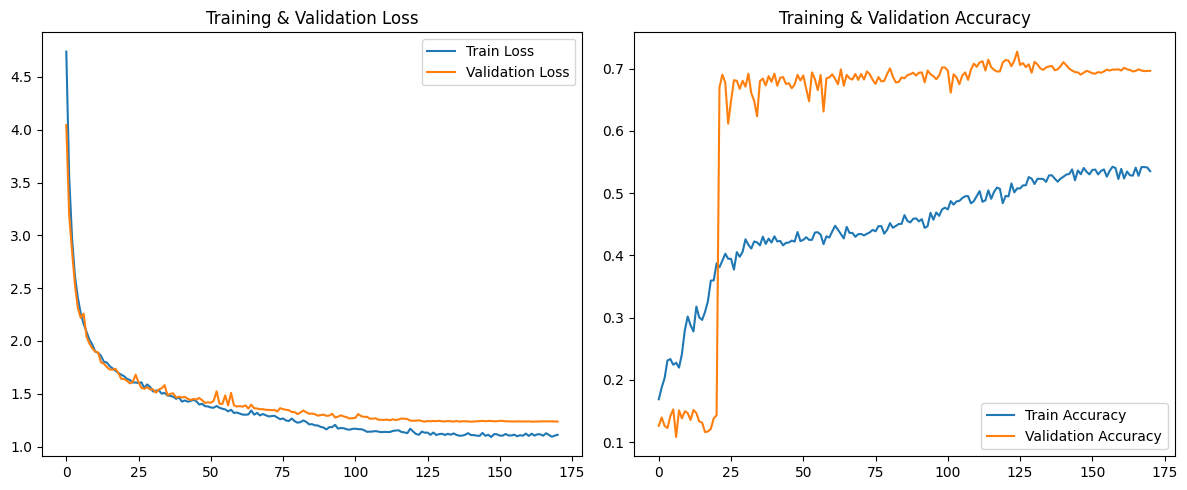

In [9]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

219/219 [==============================] - 97s 442ms/step


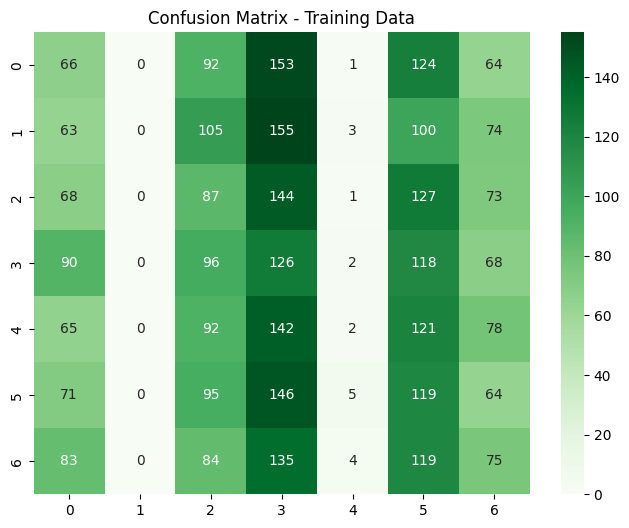

126/126 [==============================] - 34s 272ms/step


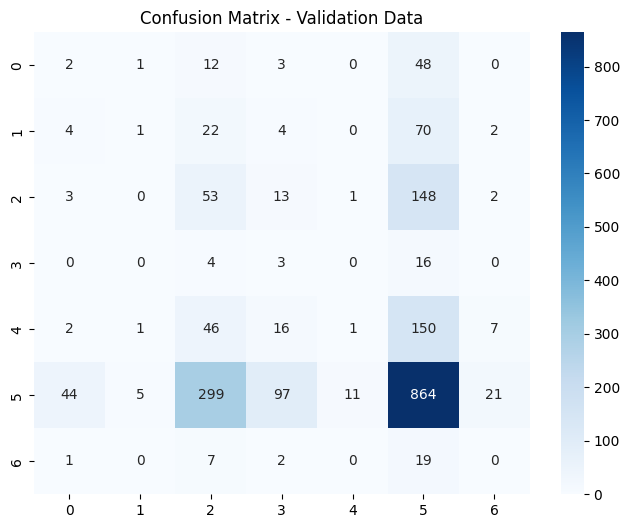

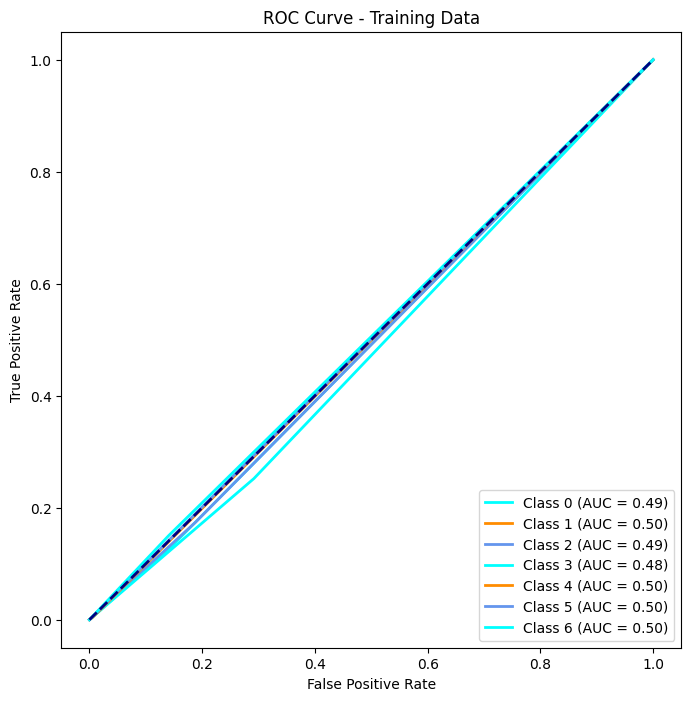

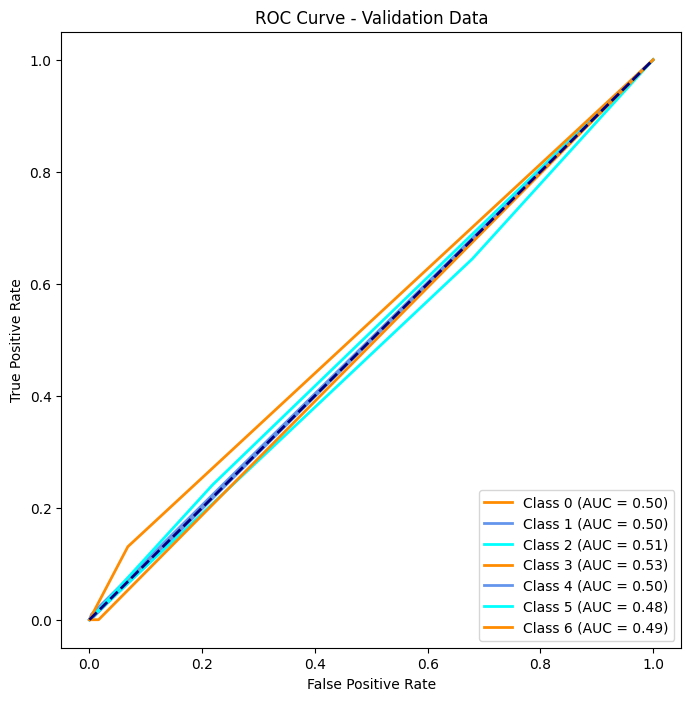

In [10]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
